In [2]:
from tools import *
from config import *

exp = "final"
sinister = "firepoint"
resolution = '2x2'

dico = read_object('break_point_dict.pkl', Path(exp + '/' + sinister + '/' + resolution  + '/' + 'train' + '/' + 'varOnValue' + '/' + 'full_0_10_100_PrcpForKMEANS_kmeans_10'))
dico

ModuleNotFoundError: No module named 'GNN'

In [19]:
def add_time_columns(array, integer_param, dataframe, train_features, features_name):
    """
    For each integer between 1 and the integer parameter,
    the function iterates through the array of column names and adds to the dataframe
    the values of the method applied to each element of the array.
    The elements are created as {column}_{method}.
    The final column name is {column}_{method}_{integer}.

    :param array: List of column names to process
    :param integer_param: Integer specifying the range of integers to iterate over
    :param dataframe: The pandas DataFrame to which new columns will be added
    :return: The updated DataFrame with new columns added
    """
    dataframe = dataframe.copy()
    unode = dataframe['id'].unique()

    # Dictionary of available methods
    methods_dict = {
        'mean': lambda x: np.nanmean(x),
        'sum': lambda x: np.nansum(x),
        'max': lambda x: np.nanmax(x),
        'min': lambda x: np.nanmin(x),
        'std': lambda x: np.nanstd(x),
        'grad': lambda x : nan_gradient(x)
    }
    new_fet = []
    # List of methods you want to apply
    for i in range(1, integer_param + 1):
        for column in array:
            vec = column.split('_')
            if len(vec) == 2:
                column_name, method_name = vec[0], vec[1]
            else:
                column_name, method_name = vec[0] + '_' + vec[1] + '_' + vec[1], vec[2]

            if 'Calendar' in vec[0] and 'Calendar' in train_features:
                columns = calendar_variables
            elif 'air' in vec[0] and 'air' in train_features:
                columns = air_variables
            elif 'Historical' in column_name and 'Historical' in train_features:
                columns = historical_variables
            elif 'AutoRegressionBin' in vec[0] and 'AutoRegressionBin' in train_features:
                columns = [f'AutoRegressionBin-{bin_fet}' for bin_fet in auto_regression_variable_bin]
            elif 'AutoRegressionReg' in vec[0] and 'AutoRegressionReg' in train_features:
                columns = [f'AutoRegressionReg-{reg_fet}' for reg_fet in auto_regression_variable_reg]
            elif vec[0] in train_features:
                columns = [column_name]
            else:
                continue

            for col in columns:
                for node in unode:
                    index = dataframe[dataframe['id'] == node].index
                    if method_name in methods_dict:
                        if col in features_name:
                            new_column_name = f"{col}_{method_name}_{i}"
                            if new_column_name not in list(dataframe.columns):
                                print(f'{new_column_name}')
                                dataframe[new_column_name] = 0.0
                            dataframe.loc[index, new_column_name] = dataframe.loc[index, col].rolling(window=i+1).apply(methods_dict[method_name], raw=True)
                            if new_column_name not in new_fet:
                                new_fet.append(new_column_name)
                        else:
                            for spatial_method in METHODS_SPATIAL:
                                if f'{col}_{spatial_method}' in features_name:
                                    new_column_name = f"{col}_{spatial_method}_{method_name}_{i}"
                                    if new_column_name not in list(dataframe.columns):
                                        print(f'{new_column_name}')
                                        dataframe[new_column_name] = 0.0
                                    dataframe.loc[index, new_column_name] = dataframe.loc[index, f'{col}_{spatial_method}'].rolling(window=i+1).apply(methods_dict[method_name], raw=True)
                                    if new_column_name not in new_fet:
                                        new_fet.append(new_column_name)
                    else:
                        raise ValueError(f"Unknown method '{method_name}'")
                
                    if col in features_name:
                        new_column_name_shift = f"{col}_-{i}"
                        if new_column_name_shift not in list(dataframe.columns):
                            print(f'{new_column_name_shift}')
                            dataframe[new_column_name_shift] = np.nan
                        dataframe.loc[index, new_column_name_shift] = dataframe.loc[index, col].shift(i)
                        if new_column_name not in new_fet:
                            new_fet.append(new_column_name_shift)
                    else:
                        for spatial_method in METHODS_SPATIAL:
                            if f'{col}_{spatial_method}' in features_name:
                                new_column_name_shift = f"{col}_{spatial_method}_-{i}"
                                if new_column_name_shift not in list(dataframe.columns):
                                    dataframe[new_column_name_shift] = np.nan
                                    print(f'{new_column_name_shift}')
                                dataframe.loc[index, new_column_name_shift] = dataframe.loc[index, f'{col}_{spatial_method}'].shift(i)
                                if new_column_name not in new_fet:
                                    new_fet.append(new_column_name_shift)
                    
    return dataframe, new_fet

In [22]:
import pandas as pd
import numpy as np

# Simuler les variables et fonctions nécessaires pour le test
calendar_variables = ['Calendar_1', 'Calendar_2']
air_variables = ['air_1', 'air_2']
historical_variables = ['Historical_1', 'Historical_2']
auto_regression_variable_bin = ['bin_1', 'bin_2']
auto_regression_variable_reg = ['reg_1', 'reg_2']
METHODS_SPATIAL = ['spatial_1', 'spatial_2']

# Fonction simulée pour calculer le gradient
def nan_gradient(x):
    if len(x) > 1:
        return np.gradient(x)[-1] if not np.isnan(x).all() else np.nan
    return np.nan

# Créer un DataFrame d'exemple
data = {
    'id': [1, 1, 1, 2, 2, 2],
    'air_1': [10, 20, 30, 5, 15, 25],
    'Historical_1': [2, 1, 3, 4, 5, 6],
}
df = pd.DataFrame(data)

# Paramètres pour le test
array = ['air_mean', 'Historical_max']
integer_param = 2
train_features = ['air', 'Historical']
features_name = ['air_1', 'Historical_1']

# Appeler la fonction
updated_df, new_columns = add_time_columns(
    array=array,
    integer_param=integer_param,
    dataframe=df,
    train_features=train_features,
    features_name=features_name
)

# Afficher les résultats pour validation
print("Updated DataFrame:")
print(updated_df)
print("\nNew columns added:")
print(new_columns)


air_1_mean_1
air_1_-1
Historical_1_max_1
Historical_1_-1
air_1_mean_2
air_1_-2
Historical_1_max_2
Historical_1_-2
Updated DataFrame:
   id  air_1  Historical_1  air_1_mean_1  air_1_-1  Historical_1_max_1  \
0   1     10             2           NaN       NaN                 NaN   
1   1     20             1          15.0      10.0                 2.0   
2   1     30             3          25.0      20.0                 3.0   
3   2      5             4           NaN       NaN                 NaN   
4   2     15             5          10.0       5.0                 5.0   
5   2     25             6          20.0      15.0                 6.0   

   Historical_1_-1  air_1_mean_2  air_1_-2  Historical_1_max_2  \
0              NaN           NaN       NaN                 NaN   
1              2.0           NaN       NaN                 NaN   
2              1.0          20.0      10.0                 3.0   
3              NaN           NaN       NaN                 NaN   
4              4.0

In [3]:
import pandas as pd

# Exemple de données
data = {
    'graph_id': ['A', 'A', 'A', 'A', 'A', 'A'],
    'time': [1, 2, 3, 1, 2, 3],
    'temp': [7, 8, 10, 0, 1, 5],
    'value': [10, 20, 30, 15, 25, 35]
}

# Création du DataFrame
df = pd.DataFrame(data)

print("DataFrame original :")
print(df)


DataFrame original :
  graph_id  time  temp  value
0        A     1     7     10
1        A     2     8     20
2        A     3    10     30
3        A     1     0     15
4        A     2     1     25
5        A     3     5     35


In [13]:
# Appliquer un décalage par groupe
import numpy as np
df['shifted_value_temp'] = df.groupby('graph_id')['temp'].rolling(3).apply(np.nansum)

print("\nDataFrame après application de shift :")
print(df)


TypeError: incompatible index of inserted column with frame index

In [15]:
df.groupby('graph_id')['temp'].rolling(3).apply(np.nansum)

graph_id   
A         0     NaN
          1     NaN
          2    25.0
          3    18.0
          4    11.0
          5     6.0
Name: temp, dtype: float64

In [256]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def sigmoid_derivative(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

def sigmoid_hess(x):
        """Hessian of sigmoid."""
        sig = sigmoid(x)
        return sig * (1 - sig) * (1 - 2 * sig)

def sig_loss_adapated(y_pred, y_true):

    y_true_zero = y_true == 0
    y_true_event = y_true > 0
    y_pred_zeros = y_pred == 0
    y_pred_event = y_pred > 0

    over_estimation = y_pred > y_true
    under_estimation = y_pred < y_true
    good_estimation = y_pred == y_true

    losses = np.zeros(y_true.shape)

    def sig_loss(x, y, bias, factor):
        diff = x - y
        diff2 = (diff + bias)**factor
        mask = sigmoid(diff)
        losses = diff2 * (1 - mask) + diff2 * mask * 2
        return losses
    
    y_true_zero = y_true == 0
    y_true_event = y_true > 0
    y_pred_zeros = y_pred == 0
    y_pred_event = y_pred > 0

    over_estimation = y_pred > y_true
    under_estimation = (y_pred < y_true)
    good_estimation = y_pred == y_true

    mask = (y_true_zero) & (over_estimation)
    losses[mask] = sig_loss(y_pred[mask], y_true[mask], 0, 4)

    mask = (y_true_event) & (y_pred_zeros)
    losses[mask] = sig_loss(y_pred[mask], y_true[mask], 0, 4)

    mask = (y_true_event) & (over_estimation)
    losses[mask] = sig_loss(y_pred[mask], y_true[mask], 0, 2)
    
    mask = (y_true_event) & (under_estimation) & (y_pred_event)
    losses[mask] = sig_loss(y_pred[mask], y_true[mask], 0, 2)

    mask = good_estimation
    losses[mask] = 0

    return losses

def sigmoid_adjusted_loss_adapted(y_pred, y, sample_weight=None):
    """Compute gradient and Hessian of the loss function with respect to y_pred."""

    y_true = np.copy(y)

    def sigmoid_grad(x):
        """Gradient of sigmoid."""
        sig = sigmoid(x)
        return sig * (1 - sig)

    def sigmoid_hess(x):
        """Hessian of sigmoid."""
        sig = sigmoid(x)
        return sig * (1 - sig) * (1 - 2 * sig)

    def sig_loss_grad(x, y, bias, factor):

        """Gradient of the loss function."""
        diff = x - y
        diff_bias = diff + bias

        sig = sigmoid(diff_bias)
        
        diff_factor = diff_bias**factor

        diff_factor_1 = factor * (diff_bias ** (factor - 1))

        return diff_factor_1 * (1 - sig) + diff_factor * -sigmoid_grad(diff_bias) + 2 * diff_factor_1 * sig + 2 * sigmoid_grad(diff_bias) * diff_factor

    def sig_loss_hess(x, y, bias, factor):
        """Hessian of the loss function."""

        diff = x - y
        diff_bias = diff + bias
        sig = sigmoid(diff_bias)

        diff_factor = diff_bias**factor
        diff_factor_1 = factor * (diff_bias ** (factor - 1))
        diff_factor_2 = factor * (factor - 1) * (diff_bias ** (factor - 2))

        hessian =  diff_factor_2 * (1 - sig) + diff_factor_1 * -sigmoid_grad(diff_bias) + diff_factor_1 * -sigmoid_grad(diff_bias) + diff_factor * -sigmoid_hess(diff_bias) + 2 * diff_factor_2 * sig + 2 * sigmoid_grad(diff_bias) * diff_factor_1 + 2 * sigmoid_hess(diff_bias) * diff_factor + 2 * diff_factor_1 * sigmoid_grad(diff_bias)

        return hessian
    
    y_true_zero = y_true == 0
    y_true_event = y_true > 0
    y_pred_zeros = y_pred == 0
    y_pred_event = y_pred > 0

    over_estimation = y_pred > y_true
    under_estimation = (y_pred < y_true)
    good_estimation = y_pred == y_true

    grad = np.zeros(y_true.shape)
    hess = np.zeros(y_true.shape)
    
    mask = (y_true_zero) & (over_estimation)
    grad[mask] = sig_loss_grad(y_pred[mask], y_true[mask], 0, 2)
    hess[mask] = sig_loss_hess(y_pred[mask], y_true[mask], 0, 2)

    mask = (y_true_event) & (y_pred_zeros)
    grad[mask] = sig_loss_grad(y_pred[mask], y_true[mask], 0, 2)
    hess[mask] = sig_loss_hess(y_pred[mask], y_true[mask], 0, 2)

    mask = (y_true_event) & (over_estimation)
    grad[mask] = sig_loss_grad(y_pred[mask], y_true[mask], 0, 2)
    hess[mask] = sig_loss_hess(y_pred[mask], y_true[mask], 0, 2)
    
    mask = (y_true_event) & (under_estimation) & (y_pred_event)
    grad[mask] = sig_loss_grad(y_pred[mask], y_true[mask], 0, 2)
    hess[mask] = sig_loss_hess(y_pred[mask], y_true[mask], 0, 2)

    mask = good_estimation
    grad[mask] = 0
    hess[mask] = 0
    
    #grad = sig_loss_grad(y_pred, y_true, 0, 2)
    #hess = sig_loss_hess(y_pred, y_true, 0, 2)

    if sample_weight is not None:
        grad *= sample_weight
        hess *= sample_weight

    return grad, hess

def sigmoid_adjusted_loss(y_pred, y, sample_weight=None):
    y_true = np.copy(y)

    diff = y_pred - y_true
    diff2 = diff ** 2
    
    # Gradient computation
    grad = 2 * diff * (1 - sigmoid(diff)) + diff2 * -sigmoid_derivative(diff) + 4 * diff * sigmoid(diff) + 2 * diff2 * sigmoid_derivative(diff) 
    
    # Hessian computation
    sig = sigmoid(diff)
    sig_derivative = sigmoid_derivative(diff)
    
    hess = 2 * (1 - sig) + 2 * diff * -sig_derivative + 2 * diff * -sig_derivative + diff2 * -sigmoid_hess(diff) + 4 * sig + 4 * diff * sig_derivative + 4 * diff * sig_derivative + 2 * diff2 * sigmoid_hess(diff)

    if sample_weight is not None:
        grad *= sample_weight
        hess *= sample_weight
    
    return grad, hess

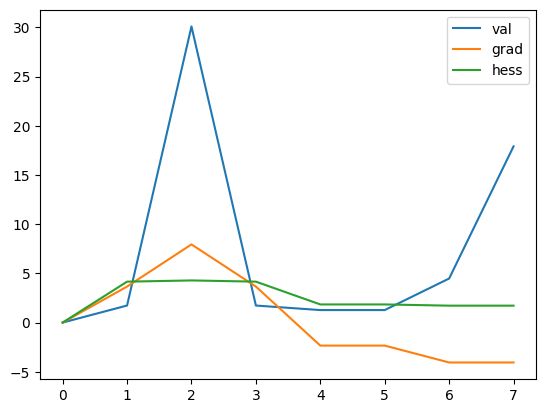

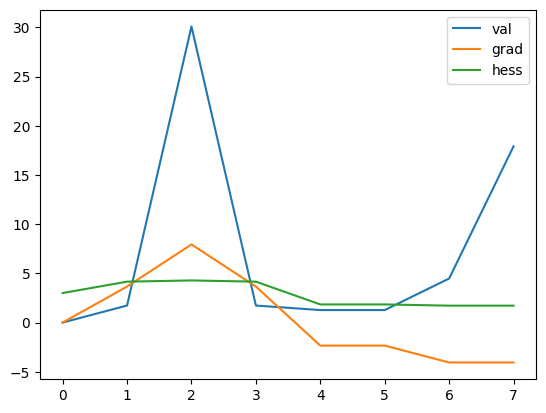

In [257]:
from cProfile import label
import matplotlib.pyplot as plt
import numpy as np

def loss(y_pred, y_true):

    y_true_zero = y_true == 0
    y_true_event = y_true > 0
    y_pred_zeros = y_pred == 0
    y_pred_event = y_pred > 0

    over_estimation = y_pred > y_true
    under_estimation = y_pred < y_true
    good_estimation = y_pred == y_true

    losses = np.zeros(y_true.shape)

    def sig_loss(x, y, bias, factor):
        diff = x - y
        diff2 = (diff + bias)**factor
        mask = sigmoid(diff)
        losses = diff2 * (1 - mask) + diff2 * mask * 2
        return losses
    
    def sig_loss_2(x, y, bias, factor):
        diff = y - x
        diff2 = (diff + bias)**factor
        mask = sigmoid(diff)
        losses = diff2 * (1 - mask) + diff2 * mask * 2
        return losses

    mask = (y_true_zero) & (over_estimation)
    losses[mask] = sig_loss(y_pred[mask], y_true[mask], 1, 2)

    mask = good_estimation
    losses[mask] = 0

    mask = (y_true_event) & (over_estimation)
    losses[mask] = sig_loss(y_pred[mask], y_true[mask], 0, 2)

    mask = (y_true_event) & (under_estimation) & (y_pred_event)
    losses[mask] = sig_loss_2(y_pred[mask], y_true[mask], 0, 2)

    mask = (y_true_event) & (under_estimation) & (y_pred_zeros)
    losses[mask] = sig_loss(y_true[mask], y_pred[mask], 1, 2)

    return losses

def loss2(y_pred, y_true):
    diff = y_pred - y_true
    diff2 = diff**2
    mask = sigmoid(diff)
    losses = diff2 * (1 - mask) + diff2 * mask * 2
    return losses

x = np.asarray([0, 1, 2, 2, 0, 0, 1, 0])
y = np.asarray([0, 0, 0, 1, 1, 1, 3, 2])

loss_values = sig_loss_adapated(x, y)

grad, hes = sigmoid_adjusted_loss_adapted(x, y)

plt.plot(loss_values, label='val')
plt.plot(grad, label='grad')
plt.plot(hes, label='hess')
plt.legend()

plt.figure()

grad, hes = sigmoid_adjusted_loss(x, y)

plt.plot(loss_values, label='val')
plt.plot(grad, label='grad')
plt.plot(hes, label='hess')
plt.legend()

In [253]:
[['AutoRegressionBin-B-1' '8']
 ['calendar_mean' '7']
 ['dayofyear' '7']
 ['bui_mean' '7']
 ['profondeur_nappe_min' '7']
 ['dmc_mean' '7']
 ['O3' '6']
 ['profondeur_nappe_mean' '6']
 ['temp_mean' '6']
 ['wdir16_max' '6']
 ['dailySeverityRating_mean' '6']
 ['bui_max' '6']
 ['temp_min' '6']
 ['dmc_max' '6']
 ['calendar_sum' '6']
 ['isi_max' '6']
 ['rhum_min' '6']
 ['wdir_mean' '6']
 ['nesterov_max' '6']
 ['temp16_min' '6']
 ['ffmc_mean' '6']
 ['PasDeRoute_mean' '6']
 ['niveau_nappe_eau_max' '6']
 ['fwi_min' '6']
 ['temp16_mean' '6']
 ['fwi_mean' '6']
 ['wspd_mean' '6']
 ['niveau_nappe_eau_mean' '6']
 ['wdir_max' '6']
 ['rhum_mean' '6']
 ['nesterov_mean' '6']
 ['angstroem_min' '6']
 ['niveau_nappe_eau_min' '6']
 ['wspd16_min' '6']
 ['angstroem_max' '6']
 ['rhum_max' '6']
 ['dc_max' '6']
 ['calendar_max' '6']
 ['12_mean' '6']
 ['cluster_encoder' '6']
 ['bui_min' '5']
 ['fwi_max' '5']
 ['dwpt16_mean' '5']
 ['profondeur_nappe_max' '5']
 ['days_since_rain_max' '5']
 ['12_max' '5']
 ['days_since_rain_mean' '5']
 ['days_since_rain_min' '5']
 ['kbdi_max' '5']
 ['sum_consecutive_rainfall_mean' '5']
 ['temp16_max' '5']
 ['wdir_min' '5']
 ['id_encoder_mean' '5']
 ['isi_mean' '5']
 ['rhum16_mean' '5']
 ['holidaysBorder' '5']
 ['holidays' '5']
 ['wspd_min' '5']
 ['rhum16_max' '5']
 ['PasDeRoute_max' '5']
 ['wdir16_min' '5']
 ['isi_min' '5']
 ['dc_min' '5']
 ['munger_mean' '5']
 ['couvrefeux' '5']
 ['sum_rain_last_7_days_max' '5']
 ['sum_rain_last_7_days_mean' '5']
 ['ffmc_max' '5']
 ['wspd16_max' '5']
 ['wspd_max' '5']
 ['wdir16_mean' '5']
 ['sum_rain_last_7_days_min' '5']
 ['temp_max' '5']
 ['dwpt16_max' '5']
 ['dwpt_max' '5']
 ['12_min' '5']
 ['nesterov_min' '5']
 ['id_encoder_min' '5']
 ['dmc_min' '5']
 ['prec24h_max' '5']
 ['dwpt_mean' '5']
 ['dailySeverityRating_min' '5']
 ['munger_min' '5']
 ['rhum16_min' '5']
 ['dailySeverityRating_max' '5']
 ['month' '5']
 ['PM25' '5']
 ['NO2' '5']
 ['kbdi_min' '5']
 ['angstroem_mean' '5']
 ['kbdi_mean' '5']
 ['dwpt16_min' '5']
 ['prec24h_mean' '5']
 ['dc_mean' '5']
 ['PM10' '5']
 ['cosia_encoder_max' '4']
 ['foret_encoder_mean' '4']
 ['Pin laricio, pin noir_max' '4']
 ['argile_encoder_max' '4']
 ['prec24h16_mean' '4']
 ['Pin sylvestre_max' '4']
 ['sum_snow_last_7_days_mean' '4']
 ['secondary_mean' '4']
 ['Pin autre_max' '4']
 ['prcp_mean' '4']
 ['snow24h16_max' '4']
 ['motorway_mean' '4']
 ['tertiary_mean' '4']
 ['tertiary_max' '4']
 ['sum_consecutive_rainfall_min' '4']
 ['Mélèze_max' '4']
 ['Douglas_max' '4']
 ['departement_encoder' '4']
 ['Hêtre_max' '4']
 ['ffmc_min' '4']
 ['prcp16_mean' '4']
 ['Water surface_max' '4']
 ['NC_max' '4']
 ['cosia_encoder_min' '4']
 ['Deciduous_max' '4']
 ['Pins mélangés_max' '4']
 ['Conifères_max' '4']
 ['prcp_max' '4']
 ['Hêtre_mean' '4']
 ['Building_mean' '4']
 ['Sapin, épicéa_mean' '4']
 ['population_max' '4']
 ['snow24h16_mean' '4']
 ['Conifer_max' '4']
 ['Shrubland_mean' '4']
 ['Shrubland_min' '4']
 ['argile_encoder_mean' '4']
 ['snow24h_min' '4']
 ['snow24h16_min' '4']
 ['Robinier_max' '4']
 ['cosia_encoder_mean' '4']
 ['Chênes décidus_max' '4']
 ['Crop_max' '4']
 ['sum_snow_last_7_days_min' '4']
 ['primary_mean' '4']
 ['snow24h_max' '4']
 ['Douglas_mean' '4']
 ['Shrubland_max' '4']
 ['Feuillus_mean' '4']
 ['Mixtes_max' '4']
 ['Chênes décidus_mean' '4']
 ['prec24h16_max' '4']
 ['motorway_max' '4']
 ['Mixtes_mean' '4']
 ['prec24h16_min' '4']
 ['Deciduous_mean' '4']
 ['Bare soil_mean' '4']
 ['Bare soil_max' '4']
 ['elevation_mean' '4']
 ['Conifer_mean' '4']
 ['prec24h_min' '4']
 ['elevation_min' '4']
 ['path_mean' '4']
 ['ramadan' '4']
 ['Feuillus_max' '4']
 ['dwpt_min' '4']
 ['path_max' '4']
 ['wspd16_mean' '4']
 ['Lawn_mean' '4']
 ['Conifères_mean' '4']
 ['foret_encoder_min' '4']
 ['elevation_max' '4']
 ['foret_encoder_max' '4']
 ['Peuplier_max' '4']
 ['id_encoder_max' '4']
 ['Châtaignier_max' '4']
 ['sum_consecutive_rainfall_max' '4']
 ['Building_max' '4']
 ['Lawn_max' '4']
 ['Crop_mean' '4']
 ['population_mean' '4']
 ['calendar_min' '4']
 ['snow24h_mean' '4']
 ['Pin maritime_max' '4']
 ['primary_max' '4']
 ['sum_snow_last_7_days_max' '4']
 ['Châtaignier_mean' '4']
 ['Sapin, épicéa_max' '4']
 ['Water surface_mean' '4']
 ['secondary_max' '4']
 ['NR_max' '4']
 ['munger_max' '4']
 ['prcp16_max' '4']
 ['NC_mean' '3']
 ['Pin sylvestre_mean' '3']]


<>:1: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
<>:1: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
/tmp/ipykernel_2864620/2725104595.py:1: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
  [['AutoRegressionBin-B-1' '8']
/tmp/ipykernel_2864620/2725104595.py:1: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
  [['AutoRegressionBin-B-1' '8']
/tmp/ipykernel_2864620/2725104595.py:1: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
  [['AutoRegressionBin-B-1' '8']
/tmp/ipykernel_2864620/2725104595.py:1: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
  [['AutoRegressionBin-B-1' '8']
/tmp/ipykernel_2864620/2725104595.py:1: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
  [['

TypeError: list indices must be integers or slices, not str

In [1]:
r = ['graph_id', 'id', 'longitude', 'latitude', 'departement', 'date', 'weight', 'days_until_next_event']
r[[0,1,2,5]]

TypeError: list indices must be integers or slices, not list

In [118]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

def mae_per_class_recall(y_true, y_pred, classes):
    """
    Calculate the Mean Absolute Error (MAE) for each class based on the absolute 
    distance between the true and predicted values, considering recall perspective.

    Parameters:
        y_true (array-like): Ground truth labels.
        y_pred (array-like): Predicted labels.
        classes (array-like): Unique classes to consider.

    Returns:
        dict: A dictionary where keys are class labels and values are the MAE for each class,
              including a 'mean_mae' key for the overall mean MAE.
    """
    # Dictionnaire pour stocker la MAE par classe
    mae_by_class = {}
    
    mae_values = []  # Stocker les MAE pour le calcul de la moyenne
    
    for cls in classes:
        # Masquer les valeurs pour la classe en cours
        mask = (y_true == cls)
        if not np.any(mask):  # Vérifie si la classe est présente
            continue
        
        # Calcul de la MAE pour la classe
        mae = np.mean(np.abs(y_true[mask] - y_pred[mask]))
        
        # Ajouter la MAE pour cette classe
        mae_by_class[cls] = mae
        mae_values.append(mae)
    
    # Calculer la moyenne des MAE et l'ajouter au dictionnaire
    mae_by_class['mean_mae'] = np.mean(mae_values) if mae_values else 0.0
    
    return mae_by_class

def mae_per_class_pre(y_true, y_pred, classes):
    """
    Calculate the Mean Absolute Error (MAE) for each class based on the absolute 
    distance between the true and predicted values, considering precision perspective.

    Parameters:
        y_true (array-like): Ground truth labels.
        y_pred (array-like): Predicted labels.
        classes (array-like): Unique classes to consider.

    Returns:
        dict: A dictionary where keys are class labels and values are the MAE for each class,
              including a 'mean_mae' key for the overall mean MAE.
    """
    # Dictionnaire pour stocker la MAE par classe
    mae_by_class = {}
    
    mae_values = []  # Stocker les MAE pour le calcul de la moyenne
    
    for cls in classes:
        # Masquer les valeurs pour la classe en cours
        mask = (y_pred == cls)
        if not np.any(mask):  # Vérifie si la classe est présente
            continue
        
        # Calcul de la MAE pour la classe
        mae = np.mean(np.abs(y_true[mask] - y_pred[mask]))
        
        # Ajouter la MAE pour cette classe
        mae_by_class[cls] = mae
        mae_values.append(mae)
    
    # Calculer la moyenne des MAE et l'ajouter au dictionnaire
    mae_by_class['mean_mae'] = np.mean(mae_values) if mae_values else 0.0
    
    return mae_by_class

classes = [0,1,2,3,4]

# Exemple
y_true = np.array([3, 1, 2, 4])
y_pred = np.array([1, 1, 2, 4])

print("Balanced Weighted Recall:", mae_per_class_recall(y_true, y_pred, classes))
print("Balanced Weighted Recall:", mae_per_class_pre(y_true, y_pred, classes))

Balanced Weighted Recall: {1: 0.0, 2: 0.0, 3: 2.0, 4: 0.0, 'mean_mae': 0.5}
Balanced Weighted Recall: {1: 1.0, 2: 0.0, 4: 0.0, 'mean_mae': 0.3333333333333333}


In [43]:
df = pd.DataFrame.from_dict(dico)
maxi = np.nanmax(df[df.columns].values)
df.reset_index(inplace=True)
df.rename({'index': 'class'}, axis=1, inplace=True)
df

NameError: name 'pd' is not defined

In [1]:
def check_for_linear_correlation(df):
    res = {}
    columns_feature = df.columns[1:]

    for cf in columns_feature:
        correlation = abs(df['class'].corr(df[cf]))
        if correlation > 0.7:
            res[cf] = abs(correlation)
            
    print(f'Original len of feature {len(columns_feature)}, selected features {len(res.keys())}')

    return res

correlation = check_for_linear_correlation(df)
correlation

NameError: name 'df' is not defined

In [68]:
fig, ax = plt.subplots(3, figsize=(15,5))
df[['prec24h_mean']].plot(ax=ax[0])
df[['nesterov_mean']].plot(ax=ax[1])
df[['temp_std']].plot(ax=ax[2])

<Axes: >